#####   1. Getting and preprocessing input data

If you have previously executed this step and downloaded all input data you can skip this step and proceed directly to step 2. However, if you are not sure, run step 1 and the model will either confirm that a specific data has aready been downloaded and subsequently viualize it or it will proceeed to download the data if it is not available or prior download was incomplete.

In [3]:
# Set working directory and path to shapefile of study area. This is repeated in every step to make each step independent

working_dir = '/home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test'  #provide full working directory
study_area = '/home/WUR/duku002/Scripts/NBAT/hydro/common_data/west_africa_coastal.shp'  #provide full path to shapefile of study_area
start_date = '2001-01-01'  # provide start date in format e.g. 'YYYY-MM-DD'.
end_date = '2010-12-31' # provide end date in format e.g. 'YYYY-MM-DD'

# Note that the start and end dates should cover model training and validation periods. Specific training and validation start and end
# should be provided in step 3 and 4.

Total number of images: 10

Exporting 1/10: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/vcf/2001_03_06.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/vcf


Exporting 2/10: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/vcf/2002_03_06.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/vcf


Exporting 3/10: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/vcf/2003_03_06.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/vcf


Exporting 4/10: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/vcf/2004_03_05.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/vcf


Exporting 5/10: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/vcf/2005_03_06.tif
Generating URL ...
Please 

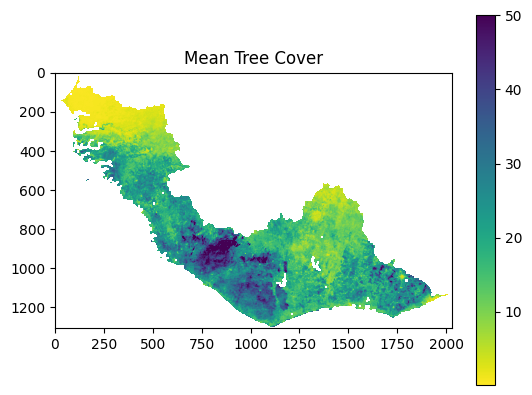

In [4]:

# download and preprocess MODIS vegetation continuous fields from Google Earth Engine Data catalog

from bakaano.tree_cover import TreeCover
vf = TreeCover(working_dir, study_area, start_date, end_date)
vf.download_tree_cover()
vf.preprocess_tree_cover()
vf.plot_tree_cover(variable='tree_cover') # options for plot are 'tree_cover' and 'herb_cover'

Total number of images: 230

Exporting 1/230: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/ndvi/2001_01_01.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/ndvi


Exporting 2/230: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/ndvi/2001_01_17.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/ndvi


Exporting 3/230: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/ndvi/2001_02_02.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/ndvi


Exporting 4/230: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/ndvi/2001_02_18.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/ndvi


Exporting 5/230: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/ndvi/2001_03_06.tif
Generating 

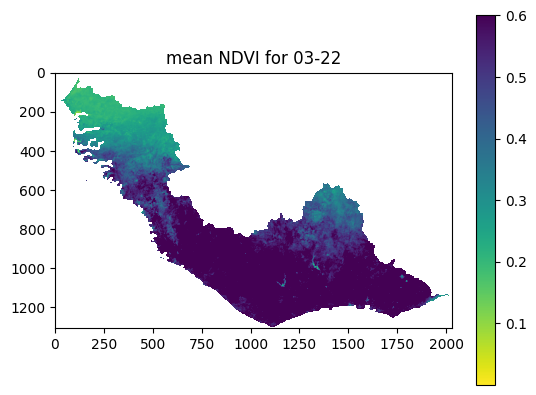

In [5]:
# download and preprocess MODIS NDVI data from Google Earth Engine Data catalog

from bakaano.ndvi import NDVI
nd = NDVI(working_dir, study_area, start_date, end_date)
nd.download_ndvi()
nd.preprocess_ndvi()
nd.plot_ndvi(interval_num=5)  # because NDVI is in 16-day interval the 'interval_num' represents a 16-day period. 
                               #Hence 0 is the first 16 day period

File downloaded successfully and saved as '/home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/elevation/hyd_glo_dem_30s.zip'
Files extracted to '/home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/elevation'
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0547171====================== ] (99% - 0.0s - 1 threads)


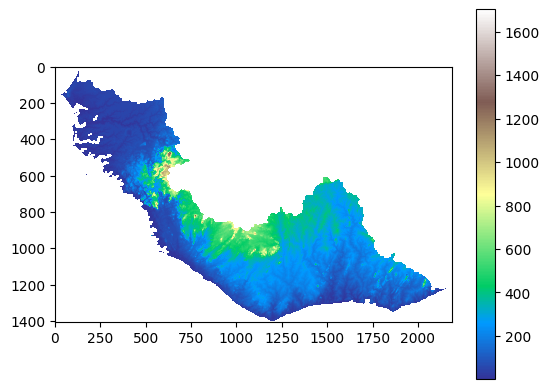

In [6]:
# Get elevation data

from bakaano.dem import DEM
dd = DEM(working_dir, study_area, local_data=False, local_data_path=None)
dd.get_dem_data()
dd.plot_dem()

File downloaded successfully and saved as '/home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/soil/AWCh3_M_sl6_1km_ll.tif'
File downloaded successfully and saved as '/home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/soil/WWP_M_sl6_1km_ll.tif'
File downloaded successfully and saved as '/home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/soil/AWCtS_M_sl6_1km_ll.tif'


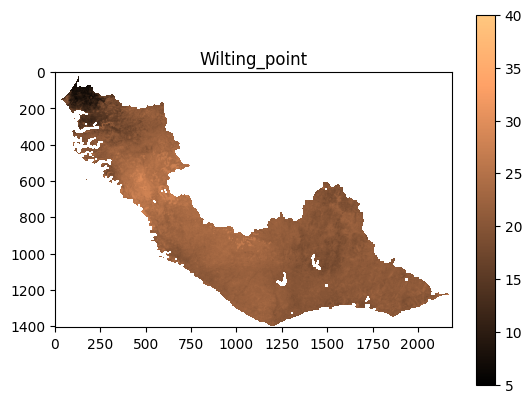

In [7]:
# Get soil data

from bakaano.soil import Soil
sgd = Soil(working_dir, study_area)
sgd.get_soil_data()
sgd.plot_soil(variable='wilting_point')  #options are 'wilting_point', 'saturation_point' and 'available_water_content'

In [ ]:
# Get meteo data

from bakaano.meteo import Meteo
cd = Meteo(working_dir, study_area, start_date=start_date, end_date=end_date, local_data=False, data_source='CHIRPS', 
           local_prep_path=None, local_tasmax_path=None, 
           local_tasmin_path=None, local_tmean_path=None)
cd.plot_meteo(variable='tmean', date='2006-12-01')

Total number of images: 365

Exporting 1/365: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/chirps_scratch/20010101.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/chirps_scratch


Exporting 2/365: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/chirps_scratch/20010102.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/chirps_scratch


Exporting 3/365: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/chirps_scratch/20010103.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/chirps_scratch


Exporting 4/365: /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/chirps_scratch/20010104.tif
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/chirps_scratch


Exporting 5/365: /home/WUR/duku002/

ERROR 1: PROJ: proj_create_from_database: Open of /home/WUR/duku002/miniconda3/envs/dlenv/share/proj failed


Bulk CHIRPS and ERA5 download complete. Checking for missing files...
Missing CHIRPS dates: 1
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/chirps_scratch/20100228.precipitation.tif
Downloaded CHIRPS for 2010-02-28
Missing ERA5 dates: 3
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/era5_scratch/20020129.temperature_2m_min.tif
Downloaded temperature_2m_min for 2002-01-29
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/era5_scratch/20020129.temperature_2m_max.tif
Downloaded temperature_2m_max for 2002-01-29
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/era5_scratch/20020129.temperature_2m.tif
Downloaded temperature_2m for 2002-01-29
Generating URL ...
Please wait ...
Data downloaded to /home/WUR/duku002/Scripts/NBAT/hydro/test

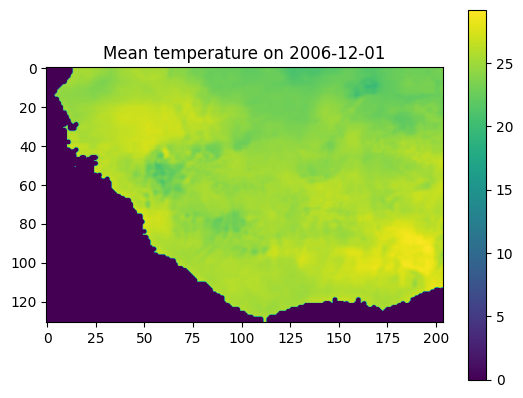

In [2]:

from bakaano.meteo import Meteo
cd = Meteo(working_dir, study_area, start_date=start_date, end_date=end_date, local_data=False, data_source='ERA5', 
           local_prep_path=None, local_tasmax_path=None, 
           local_tasmin_path=None, local_tmean_path=None)
cd.plot_meteo(variable='tmean', date='2006-12-01')

#####   2. Computing runoff and routing to river network

In [1]:
# Set working directory and path to shapefile of study area. This is repeated in every step to make each step independent

working_dir = '/home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test'  #provide full working directory
study_area = '/home/WUR/duku002/Scripts/NBAT/hydro/common_data/west_africa_coastal.shp'  #provide full path to shapefile of study_area
start_date = '2001-01-01'  # provide start date in format e.g. 'YYYY-MM-DD'.
end_date = '2010-12-30' # provide end date in format e.g. 'YYYY-MM-DD'


In [2]:

from bakaano.veget import VegET
vg = VegET(working_dir, study_area, start_date, end_date, climate_data_source='CHIRPS')
vg.compute_veget_runoff_route_flow()

ERROR 1: PROJ: proj_create_from_database: Open of /home/WUR/duku002/miniconda3/envs/dlenv/share/proj failed


Computing VegET runoff and routing flow to river network
     - CHIRPS daily data already exists in /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/CHIRPS; skipping download.




     Simulating runoff:   0%|          | 0/3651 [00:00<?, ?day/s]

    Computing surface runoff and routing flow to river channels in year 1


     Simulating runoff:  10%|▉         | 365/3651 [13:51<2:06:14,  2.31s/day]

    Computing surface runoff and routing flow to river channels in year 2


     Simulating runoff:  20%|█▉        | 730/3651 [27:45<1:49:25,  2.25s/day]

    Computing surface runoff and routing flow to river channels in year 3


     Simulating runoff:  30%|██▉       | 1095/3651 [41:22<1:31:54,  2.16s/day]

    Computing surface runoff and routing flow to river channels in year 4


     Simulating runoff:  40%|███▉      | 1460/3651 [54:47<1:19:40,  2.18s/day]

    Computing surface runoff and routing flow to river channels in year 5


     Simulating runoff:  50%|████▉     | 1825/3651 [1:08:23<1:07:37,  2.22s/day]

    Computing surface runoff and routing flow to river channels in year 6


     Simulating runoff:  60%|█████▉    | 2190/3651 [1:22:07<53:52,  2.21s/day]  

    Computing surface runoff and routing flow to river channels in year 7


     Simulating runoff:  70%|██████▉   | 2555/3651 [1:35:40<40:41,  2.23s/day]

    Computing surface runoff and routing flow to river channels in year 8


     Simulating runoff:  80%|███████▉  | 2920/3651 [1:49:23<26:54,  2.21s/day]

    Computing surface runoff and routing flow to river channels in year 9


     Simulating runoff:  90%|████████▉ | 3285/3651 [2:02:50<13:23,  2.19s/day]

    Computing surface runoff and routing flow to river channels in year 10


     Simulating runoff: 100%|█████████▉| 3650/3651 [2:16:21<00:02,  2.44s/day]

    Computing surface runoff and routing flow to river channels in year 11


     Simulating runoff: 100%|██████████| 3651/3651 [2:16:24<00:00,  2.24s/day]


Completed. Routed runoff data saved to /home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test/runoff_output/wacc_sparse_arrays.pkl


#####   3. Training Bakaano-Hydro model 

In [ ]:
# Set working directory and path to shapefile of study area. This is repeated in every step to make each step independent

working_dir = '/home/WUR/duku002/Scripts/NBAT/hydro/test_github_code/test'  #provide full working directory
study_area = '/home/WUR/duku002/Scripts/NBAT/hydro/common_data/west_africa_coastal.shp'  #provide full path to shapefile of study_area
start_date = '2001-01-01'  # provide start date in format e.g. 'YYYY-MM-DD'.
end_date = '2010-12-30' # provide end date in format e.g. 'YYYY-MM-DD'


In [ ]:
#TRAINING THE NEURAL NETWORK MODEL
# Initialize  instance of Bakaano-Hydro model

train_start_date = '2001-01-01'
train_end_date = '2007-12-31'
grdc_netcdf = '/lustre/backup/WUR/ESG/duku002/NBAT/hydro/input_data/GRDC-Daily-africa-south-america.nc'   #provide path to netcdf format of observed streamflow obtained from GRDC
climate_data_source = 'CHIRPS'

from bakaano.runner import BakaanoHydro
bk = BakaanoHydro(  
    working_dir,
    study_area,
    start_date,
    end_date,
    climate_data_source=climate_data_source
)

bk.train_streamflow_model(train_start=train_start_date, train_end=train_end_date, grdc_netcdf=grdc_netcdf,  
                          loss_fn='laplacian_nll', num_input_branch=2, lookback=365, batch_size=256, num_epochs=100)

#####   4. Evaluating Bakaano-Hydro model performance

In [ ]:
# Set working directory and path to shapefile of study area. This is repeated in every step to make each step independent
 
working_dir = '/lustre/backup/WUR/ESG/duku002/NBAT/hydro/niger'  #provide full working directory
study_area = '/home/WUR/duku002/Scripts/NBAT/hydro/common_data/niger.shp'  #provide full path to shapefile of study_area
start_date = '1981-01-01'  # provide start date in format e.g. 'YYYY-MM-DD'.
end_date = '2016-12-31' # provide end date in format e.g. 'YYYY-MM-DD'

2025-04-15 20:00:56.698169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744740056.717615  995554 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744740056.723749  995554 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Available station names:
['AKKA' 'ALCONGUI' 'ANSONGO' 'BADEGUICHERI' 'BANANKORO' 'BARO' 'BAROU'
 'BENENY-KEGNY' 'BOUGOUNI' 'CAMPEMENT DU DOUBLE VE' 'COUBERI' 'DABOLA'
 'DEBETE' 'DIALAKORO' 'DIOILA' 'DIONGORE AMONT' 'DIRE' 'DJIRILA' 'DOLBEL'
 'DOUNA' 'FARANAH' 'GARBE-KOUROU' 'GOUALA' 'GOUNDAM' 'GOUNOU-GAYA'
 'GUELELINKORO' 'GUINDAM ROUMDJI' 'GUINGUERINI' 'IBI' 'IRADOUGOU'
 'KAKASSI' 'KANDADJI' 'KANKAN' 'KARA' 'KE-MACINA' 'KEROU' 'KEROUANE'
 'KIRANGO AVAL' 'KISSIDOUGOU' 'KLELA' 'KOLONDIEBA' 'KOMPONGOU'
 'KONSANKORO' 'KORYOUME' 'KOULIKORO' 'KOUORO 1' 'KOUORO 2' 'KOUROUSSA'
 'KOUTAKOUKROU' 'KOUTO AMONT' 'KOUTO AVAL' 'LOKOJA' 'MADAROUNFA'
 'MADINA DIASSA' 'MALANVILLE' 'MANANKORO' 'MANDIANA' 'MOLOKORO' 'MOPTI'
 'NANTAKA (MOPTI)' 'NIAMEY' 'NIELLOUA' 'OUARAN' 'PANKOUROU' 'PAPARA'
 'PONONDOUGOU' 'PONT CAROL' 'ROUTE KANDI-BANIKOARA AMONT'
 'ROUTE KANDI-BANIKOARA AVAL' 'RTE KANDI-SEGBANA AMONT'
 'RTE KANDI-SEGBANA AVAL' 'SAMATIGUILA' 'SARAFERE' 'SELINGUE' 'SOFARA'
 'TAMOU' 'TERA' 'TIGUIBERY' 'TIL


 Please enter the station name:  FARANAH


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2025-04-15 20:03:57.047905: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 411ms/step
Nash-Sutcliffe Efficiency (NSE): 0.6556931752735922
Kling-Gupta Efficiency (KGE): 0.8254614287603348


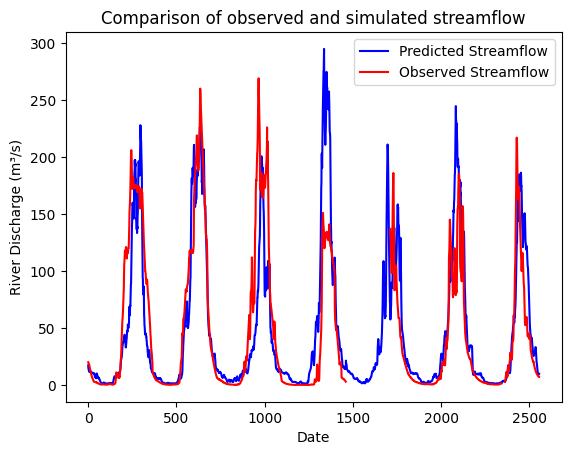

In [ ]:
model_path = f'{working_dir}/models/bakaano_model_laplacian_nll_2_branches.keras' #trained model is always saved in models folder in the working dir with a .keras extension
grdc_netcdf = '/lustre/backup/WUR/ESG/duku002/NBAT/hydro/input_data/GRDC-Daily-africa-uth-america.nc'   #provide path to netcdf format of observed streamflow obtained from GRDC
val_start_date = '1981-01-01'
val_end_date = '1988-12-31'
climate_data_source = 'CHIRPS'

from bakaano.runner import BakaanoHydro
bk = BakaanoHydro(
    working_dir,
    
    study_area,
    start_date,
    end_date,
    climate_data_source=climate_data_source
)

bk.evaluate_streamflow_model_interactively(model_path=model_path, val_start=val_start_date, val_end=val_end_date, grdc_netcdf=grdc_netcdf, 
                                           loss_fn='laplacian_nll', num_input_branch=2, lookback=365)

#####   5. Simulating streamflow series with Bakaano-Hydro

In [1]:
latlist = [13.8, 13.9, 9.15, 8.75, 10.66, 9.32, 7.8, 8.76, 6.17]
lonlist = [3.0, 4.0, 4.77, 5.91, 4.69, 4.63, 8.91, 10.82, 6.77]

In [2]:
# Set working directory and path to shapefile of study area. This is repeated in every step to make each step independent

working_dir = '/lustre/backup/WUR/ESG/duku002/NBAT/hydro/niger'
#working_dir = '/home/WUR/duku002/Scripts/NBAT/hydro/niger'  #provide full working directory
study_area = '/home/WUR/duku002/Scripts/NBAT/hydro/common_data/niger.shp'  #provide full path to shapefile of study_area
start_date = '1981-01-01'  # provide start date in format e.g. 'YYYY-MM-DD'.
end_date = '2016-12-31' #vide end date in format e.g. 'YYYY-MM-DD'
climate_data_source = 'CHELSA'

# Note that the start and end dates should cover model training and validation periods. Specific training and validation start and end
# should be provided in step 3 and 4.

In [3]:
model_path = f'{working_dir}/models/bakaano_model_laplacian_nll_2_branches.keras'
sim_start = '1981-01-01'
sim_end = '1988-12-31'

from bakaano.runner import BakaanoHydro
bk = BakaanoHydro(
    working_dir,
    study_area,
    start_date,
    end_date,
    climate_data_source=climate_data_source
)


bk.simulate_streamflow(model_path=model_path, sim_start=sim_start, sim_end=sim_end, latlist=latlist, lonlist=lonlist, 
                       loss_fn='laplacian_nll', num_input_branch=2, lookback=365)

2025-04-15 09:40:34.674038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744702834.687905 2487488 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744702834.692021 2487488 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 1. Loading runoff data and other predictors
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2025-04-15 09:43:41.203994: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


 2. Batch prediction
2557/2557 ━━━━━━━━━━━━━━━━━━━━ 236s 91ms/step
 3. Generating csv file for each coordinate
 COMPLETED! csv files available at /lustre/backup/WUR/ESG/duku002/NBAT/hydro/niger/predicted_streamflow_data
